# Company Attractiveness Classification

400 days of KPI data of 64 companies are used for classifying companies into two groups- "Good Company" & "Bad Company."  The KPIs include:
* Mobile Downloads- Number of downloads of the company's mobile app on a given day
* Mobile MAUs - Number of people who used the company's app at least once in a given month
* Web visits - Number of visits to teh company's website on a given day
* Web rank- Number of visits to the company's website on a given day (lower is better)
* Web MUVs - Number of unique visitors to the company's web site in a given month
* Monthly sales - The comapny's revenue in a given month
* FB likes - Number of likes on the company's Facebook page on a given day. <br>


### Feature Engineering
312 features are created to measure the investment opportunity of a company.  For the KPIs in the dataset, the higher the number, the better the company is.  The only exception is Web rank, where a lower number is better.  The KPIs are summarized using rolling averages.  A good company should exhibit three traits- Market dominance, Growth, and Consistency.   <br>


**Market Dominance** <br>
To assess market dominance, rank based measurements are calculated.  Companies are compared against each other for each of the KPIs.  

**Growth** <br>
To assess growth, we calculate how much the KPI has grown relative to historical average, and how much the KPI has grown relative to the current value.  The growth of the ranks of the various KPI metrics are also calculated.  
<br>
Example: <br>
growth calc relative to historical value = (Web visits 5-day moving average-Web visits 90-day moving average) / Web visits 90-day moving average<br>
A company with 1000 visits now and 10 visits before, had a 9x growth.  (1000-100)/10 = 9 <br>
<br>
growth calc relative to current value = (Web visits 5-day moving average-Web visits 90-day moving average) / Web visits 5-day moving average<br>
A company with 1000 visits now and 10 visits before, has a size of growth of 0.9 of its current value. (1000-100)/1000 = 0.9 <br>
<br>
**Consistency** <br>
To assess consistency, the changes of the KPI measurements between recent values and historical values should be small.  We want to identify companies that are leaders and maintain its leadership.  The direction of the changes in KPI also indicate if the performance of the companies have improved or worsened.  For an existing market leader, the company should have small changes in KPI measurements.  For an up-and-coming growth company, the company should see a positive improvement in KPI measurments.  
<br>
Example: <br>
Web rank difference = Web rank difference(rolling 5 day average) - Web rank difference(rolling 90 day average) should be small. 

**Why is rolling averages used?**
The advantage of rolling averages is that it smooths out some noise, and it is also easier to see the changes in a timeseries.  It is often useful to compare a short-term moving average against a longer-term moving average. In this analysis, the most recent observation of the moving averages are used for modeling. 

### Model


A LightGBM model is run, with a train/test split of 20%.  There are only 64 observations in total, so designing a good validation methodology was difficult.  If cross-validation is used on top of the train/test split, there will not be enough observation in each fold to have a good model.  The model achieved a logloss of 0.12 and AUC of 1 on the entire set.  The logloss on the validation set is 0.07.  While training, the logloss between the training and validation set was small, so over-fitting the model was not a major concern.  The model performance should be improved if more data was used.  The feature importance of the model confirmed the intuition above regarding what constitutes a good company. The feature importance are detailed later in this notebook.  In general, the most important features are based on web visits, web rank, and web MUVs.  This is also due to the fact that other KPIs did not have data for all the companies.  

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc

%matplotlib inline

In [2]:
print(os.listdir("./data"))
cwd = os.getcwd()
data_folder = 'data'

['Company Classification - data.csv', 'Company Classification - labels.csv']


In [3]:
df_data = pd.read_csv(os.path.join(cwd, data_folder, 'Company Classification - data.csv'))
df_label = pd.read_csv(os.path.join(cwd, data_folder, 'Company Classification - labels.csv'))
df_data.name = "df_data"
df_label.name = "df_label"
df_data['Date'] = pd.to_datetime(df_data['Date'])

#### Check Data

In [4]:
dfList = [df_data, df_label]
for dfs in dfList:
    print(dfs.name, dfs.shape)

df_data (61538, 4)
df_label (64, 2)


In [5]:
df_label["Label"].value_counts(normalize= True)

0.5    0.421875
0.0    0.328125
1.0    0.250000
Name: Label, dtype: float64

In [6]:
def data_summary(df):
    '''print out information about dataframe
    Argument: dataframe name
    Return: dataframe with summary figures
    '''
    temp = pd.DataFrame(data = df.isnull().sum(axis=0))
    temp.columns=['NA count']
    temp['NA %'] = temp['NA count']/(df.shape[0])*100
    temp['# unique vals'] = df.nunique(axis=0)
    temp['dtype'] =  df.dtypes
    #temp['dataset'] = df.name
    
    return temp

In [7]:
data_summary(df_data)

,NA count,NA %,# unique vals,dtype
Date,0,0.0,400,datetime64[ns]
Company,0,0.0,64,object
KPI,0,0.0,7,object
Value,0,0.0,33408,int64


In [8]:
df_data['KPI'].unique()

array(['FB likes', 'Web rank', 'Web visits', 'Mobile Downloads',
       'Monthly sales', 'Web MUVs', 'Mobile MAUs'], dtype=object)

In [9]:
df_data = df_data.set_index('Company')

#### Sort data

In [10]:
df_data = df_data.sort_values(['Date', 'Company', 'KPI'], ascending=True)

In [11]:
df_data = df_data.reset_index(drop = False)

In [12]:
df_data.head()

,Company,Date,KPI,Value
0,0216c5c3-c2aa-4c27-bd26-00aad7937899,2017-04-21,FB likes,87798
1,0216c5c3-c2aa-4c27-bd26-00aad7937899,2017-04-21,Web rank,92299
2,0216c5c3-c2aa-4c27-bd26-00aad7937899,2017-04-21,Web visits,13586
3,02d40d61-c402-46d2-bd04-96416674bcd2,2017-04-21,Mobile Downloads,53
4,02d40d61-c402-46d2-bd04-96416674bcd2,2017-04-21,Web rank,681314


### Feature Engineering

#### Process each KPI separately

#### Define Helper Functions to generate the new features

In [13]:
def getAggregation(df_data, KPI):
    '''
    Get aggregated features for the selected KPI
    '''
    
    # filter dataset to the selected KPI and rename the column as the KPI name
    subset = df_data[df_data["KPI"] == KPI]
    subset = subset.rename(columns = {'Value': KPI})
    
    # Get aggregated measures
    summary = subset.groupby(["Company", "KPI"]).agg({KPI : ['count','sum', 'min', 'max', 'mean', 'median', 'std', 'first', 'last']})
    summary.columns = ['_'.join(col).rstrip('_') for col in summary.columns.values]
    summary = summary.reset_index()
    summary = summary.set_index('Company')
    
    # Get date that reached maximum value of the selected KPI
    maxDate = subset.loc[subset.groupby("Company")[KPI].idxmax()]
    maxDate = maxDate.set_index('Company')
    maxDate = maxDate['Date']
    summary[KPI+'_maxDate'] = maxDate
    
    # get date that reached minimum value of the selected KPI
    minDate = subset.loc[subset.groupby("Company")[KPI].idxmin()]
    minDate = minDate.set_index('Company')
    minDate = minDate['Date']
    summary[KPI+'_minDate'] = minDate
    
    # Trending up?
    summary[KPI+'_maxDate>minDate'] = np.where(summary[KPI+'_maxDate']>summary[KPI+'_minDate'], 1,0)
    
    # drop column KPI
    summary = summary.drop(['KPI'], axis = 1)
    
    return summary
    

In [14]:
def rollingMean(df_data, KPI, period):
    '''
    Get the most recent rolling average of the selected KPI (single period)
    '''
    subset = df_data[df_data["KPI"] == KPI]
    summary = pd.DataFrame(subset.groupby('Company')['Value'].rolling(period).mean())
    summary = summary.groupby('Company').last()
    summary = summary.rename(columns = {'Value': str(KPI) + '_rollingMean_' + str(period)})
    
    return summary

In [15]:
def rollingMeanMultiPeriods(df_data, periodList, KPI_df, KPI ):
    '''
    Get the most recent rolling averages of the selected KPI for "multiple periods."
    periodList should list from smallest to largest of 5 periods for use in getFeatures function
    
    '''
    
    for period in periodList:
        rollingMeanTable = rollingMean(df_data, KPI, period)
        KPI_df = KPI_df.merge(rollingMeanTable, left_index = True, right_index = True, how = 'left')
        
    return KPI_df

In [16]:
def getFeatures(KPI_df, KPI, period):
    '''
    Generate other features that measures differences, growth, and ranking.
    The periods has to match the period used in 
    rollingMeanMultiPeriods.  Periods should have a length of 5.  
    Ex:
    periodList = [5, 15, 30, 60, 90]  for Daily KPIs
    periodList = [2,3,6,9,12] for Monthly KPIs
    '''
    # Differences between measures
    KPI_df[KPI+'_diffLastFirst'] = KPI_df[KPI+'_last']-KPI_df[KPI+'_first']
    KPI_df[KPI+'_diffMaxMin'] = KPI_df[KPI+'_max']-KPI_df[KPI+'_min']
    KPI_df[KPI+'_diffMaxLast'] = KPI_df[KPI+'_max']-KPI_df[KPI+'_last']
    KPI_df[KPI+'_diffMaxMinDate'] = (KPI_df[KPI+'_maxDate']-KPI_df[KPI+'_minDate']).dt.days
    
    # Growth Measurements (measure percentage of change)
    KPI_df[KPI+'_LastFirstGrowth'] = KPI_df[KPI+'_diffLastFirst'] /KPI_df[KPI+'_first']
    KPI_df[KPI+'_MaxMinGrowth'] = KPI_df[KPI+'_diffMaxMin'] /KPI_df[KPI+'_min']
    KPI_df[KPI+'_MaxLastGrowth'] = KPI_df[KPI+'_diffMaxLast']/KPI_df[KPI+'_first']
    
    # Growth Measurements (measure percentage of change)
    KPI_df[KPI+'_LastFirstGrowthL'] = KPI_df[KPI+'_diffLastFirst'] /KPI_df[KPI+'_last']
    KPI_df[KPI+'_MaxMinGrowthL'] = KPI_df[KPI+'_diffMaxMin'] /KPI_df[KPI+'_max']
    KPI_df[KPI+'_MaxLastGrowthL'] = KPI_df[KPI+'_diffMaxLast']/KPI_df[KPI+'_last']
    
    
    # Average change per day between the Min and Max value
    KPI_df[KPI+'_MaxMinGrowthDate'] = KPI_df[KPI+'_diffMaxMin']/ KPI_df[KPI+'_diffMaxMinDate']
    
    # Difference between first rolling period and each of the other rolling periods
    KPI_df[KPI+'_diffRolling'+str(period[0])+'Rolling'+str(period[4])] = KPI_df[KPI+'_rollingMean_'+str(period[0])] - KPI_df[KPI+'_rollingMean_'+str(period[4])]
    KPI_df[KPI+'_diffRolling'+str(period[0])+'Rolling'+str(period[3])] = KPI_df[KPI+'_rollingMean_'+str(period[0])] - KPI_df[KPI+'_rollingMean_'+str(period[3])]
    KPI_df[KPI+'_diffRolling'+str(period[0])+'Rolling'+str(period[2])] = KPI_df[KPI+'_rollingMean_'+str(period[0])] - KPI_df[KPI+'_rollingMean_'+str(period[2])]
    KPI_df[KPI+'_diffRolling'+str(period[0])+'Rolling'+str(period[1])] = KPI_df[KPI+'_rollingMean_'+str(period[0])] - KPI_df[KPI+'_rollingMean_'+str(period[1])]
  
    # Rank the rolling averages (compare across companies)
    KPI_df[KPI+'_rankLast'] = KPI_df[KPI+'_last'].rank(ascending = False)
    KPI_df[KPI+'_rankRolling'+str(period[0])] = KPI_df[KPI+'_rollingMean_'+str(period[0])].rank(ascending = False)
    KPI_df[KPI+'_rankRolling'+str(period[1])] = KPI_df[KPI+'_rollingMean_'+str(period[1])].rank(ascending = False)
    KPI_df[KPI+'_rankRolling'+str(period[2])] = KPI_df[KPI+'_rollingMean_'+str(period[2])].rank(ascending = False)
    KPI_df[KPI+'_rankRolling'+str(period[3])] = KPI_df[KPI+'_rollingMean_'+str(period[3])].rank(ascending = False)
    KPI_df[KPI+'_rankRolling'+str(period[4])] = KPI_df[KPI+'_rollingMean_'+str(period[4])].rank(ascending = False)

    # Differences between the most recent rank compared to other rolling periods. 
    # Meausures if the ranks improve or worsen over time  
    KPI_df[KPI+'_rankDiffLastRolling'+str(period[0])] = -KPI_df[KPI+'_rankLast'] + KPI_df[KPI+'_rankRolling'+str(period[0])] 
    KPI_df[KPI+'_rankDiffLastRolling'+str(period[1])] = -KPI_df[KPI+'_rankLast'] + KPI_df[KPI+'_rankRolling'+str(period[1])]
    KPI_df[KPI+'_rankDiffLastRolling'+str(period[2])] = -KPI_df[KPI+'_rankLast'] + KPI_df[KPI+'_rankRolling'+str(period[2])]
    KPI_df[KPI+'_rankDiffLastRolling'+str(period[3])] = -KPI_df[KPI+'_rankLast'] + KPI_df[KPI+'_rankRolling'+str(period[3])]
    KPI_df[KPI+'_rankDiffLastRolling'+str(period[4])] = -KPI_df[KPI+'_rankLast'] + KPI_df[KPI+'_rankRolling'+str(period[4])]
    
    # Measures the percentage of change of Rankings in each rolling periods compared to the most recent period.
    KPI_df[KPI+'_rankDiffGrowthLastRolling'+str(period[0])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[0])]/KPI_df[KPI+'_rankRolling'+str(period[0])] 
    KPI_df[KPI+'_rankDiffGrowthLastRolling'+str(period[1])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[1])]/KPI_df[KPI+'_rankRolling'+str(period[1])]
    KPI_df[KPI+'_rankDiffGrowthLastRolling'+str(period[2])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[2])]/KPI_df[KPI+'_rankRolling'+str(period[2])]
    KPI_df[KPI+'_rankDiffGrowthLastRolling'+str(period[3])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[3])]/KPI_df[KPI+'_rankRolling'+str(period[3])]
    KPI_df[KPI+'_rankDiffGrowthLastRolling'+str(period[4])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[4])]/KPI_df[KPI+'_rankRolling'+str(period[4])]
    
    # Measures the percentage of change of Rankings in each rolling periods compared to the most recent period.
    KPI_df[KPI+'_rankDiffGrowthLastRollingL'+str(period[0])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[0])]/KPI_df[KPI+'_rankLast']
    KPI_df[KPI+'_rankDiffGrowthLastRollingL'+str(period[1])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[1])]/KPI_df[KPI+'_rankLast']
    KPI_df[KPI+'_rankDiffGrowthLastRollingL'+str(period[2])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[2])]/KPI_df[KPI+'_rankLast']
    KPI_df[KPI+'_rankDiffGrowthLastRollingL'+str(period[3])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[3])]/KPI_df[KPI+'_rankLast']
    KPI_df[KPI+'_rankDiffGrowthLastRollingL'+str(period[4])] = KPI_df[KPI+'_rankDiffLastRolling'+str(period[4])]/KPI_df[KPI+'_rankLast']
    
    
    return KPI_df

### Mobile Downloads

Number of downloads of the company's mobile app on a given day.

In [17]:
downloads = getAggregation(df_data, 'Mobile Downloads')

In [18]:
downloads.shape

(26, 12)

In [19]:
data_summary(downloads)

,NA count,NA %,# unique vals,dtype
Mobile Downloads_count,0,0.0,24,int64
Mobile Downloads_sum,0,0.0,26,int64
Mobile Downloads_min,0,0.0,20,int64
Mobile Downloads_max,0,0.0,26,int64
Mobile Downloads_mean,0,0.0,26,float64
Mobile Downloads_median,0,0.0,25,float64
Mobile Downloads_std,0,0.0,26,float64
Mobile Downloads_first,0,0.0,22,int64
Mobile Downloads_last,0,0.0,25,int64
Mobile Downloads_maxDate,0,0.0,25,datetime64[ns]


### Web Rank

Number of visits to the company's website on a given day.

In [20]:
webRank = getAggregation(df_data, 'Web rank')
webRank = rollingMeanMultiPeriods(df_data, [5, 15, 30, 60, 90], webRank, 'Web rank' )
webRank = getFeatures(KPI_df = webRank, KPI = 'Web rank', period = [5, 15, 30, 60, 90])

In [21]:
webRank.shape

(64, 53)

In [22]:
data_summary(webRank)[data_summary(webRank)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype
Web rank_rollingMean_30,3,4.6875,61,float64
Web rank_rollingMean_60,8,12.5000,56,float64
Web rank_rollingMean_90,11,17.1875,53,float64
Web rank_diffRolling5Rolling90,11,17.1875,53,float64
Web rank_diffRolling5Rolling60,8,12.5000,56,float64
Web rank_diffRolling5Rolling30,3,4.6875,61,float64
Web rank_rankRolling30,3,4.6875,61,float64
Web rank_rankRolling60,8,12.5000,56,float64
Web rank_rankRolling90,11,17.1875,53,float64
Web rank_rankDiffLastRolling30,3,4.6875,32,float64


### FB Likes

Number of likes on the company's Facebook page on a given day.

In [23]:
fbLikes = getAggregation(df_data, 'FB likes')
fbLikes = rollingMeanMultiPeriods(df_data, [5, 15, 30, 60, 90], fbLikes, 'FB likes' )
fbLikes = getFeatures(KPI_df = fbLikes, KPI = 'FB likes', period = [5, 15, 30, 60, 90])

In [24]:
fbLikes.shape

(60, 53)

In [25]:
data_summary(fbLikes)[data_summary(fbLikes)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype
FB likes_rollingMean_60,1,1.666667,59,float64
FB likes_rollingMean_90,12,20.000000,48,float64
FB likes_diffRolling5Rolling90,12,20.000000,48,float64
FB likes_diffRolling5Rolling60,1,1.666667,59,float64
FB likes_rankRolling60,1,1.666667,59,float64
FB likes_rankRolling90,12,20.000000,48,float64
FB likes_rankDiffLastRolling60,1,1.666667,4,float64
FB likes_rankDiffLastRolling90,12,20.000000,12,float64
FB likes_rankDiffGrowthLastRolling60,1,1.666667,16,float64
FB likes_rankDiffGrowthLastRolling90,12,20.000000,39,float64


### Mobile MAUs

Number of people who used the company's app at least once in a given month

In [26]:
mau = getAggregation(df_data, 'Mobile MAUs')
mau = rollingMeanMultiPeriods(df_data, [2,3,4,5,6], mau, 'Mobile MAUs' )
mau = getFeatures(KPI_df = mau, KPI = 'Mobile MAUs', period = [2,3,4,5,6])

In [27]:
mau.shape

(10, 53)

In [28]:
data_summary(mau)[data_summary(mau)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype
Mobile MAUs_std,1,10.0,9,float64
Mobile MAUs_rollingMean_2,1,10.0,9,float64
Mobile MAUs_rollingMean_3,3,30.0,7,float64
Mobile MAUs_rollingMean_4,3,30.0,7,float64
Mobile MAUs_rollingMean_5,5,50.0,5,float64
Mobile MAUs_rollingMean_6,6,60.0,4,float64
Mobile MAUs_MaxMinGrowthDate,1,10.0,9,float64
Mobile MAUs_diffRolling2Rolling6,6,60.0,4,float64
Mobile MAUs_diffRolling2Rolling5,5,50.0,5,float64
Mobile MAUs_diffRolling2Rolling4,3,30.0,7,float64


### Web Visits

Number of visits to teh company's website on a given day.

In [29]:
visits = getAggregation(df_data, 'Web visits')
visits = rollingMeanMultiPeriods(df_data, [5, 15, 30, 60, 90], visits, 'Web visits' )
visits = getFeatures(KPI_df = visits, KPI = 'Web visits', period = [5, 15, 30, 60, 90])

In [30]:
visits.shape

(64, 53)

In [31]:
data_summary(visits)[data_summary(visits)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype
Web visits_LastFirstGrowth,3,4.6875,45,float64
Web visits_LastFirstGrowthL,3,4.6875,45,float64


### Monthly Sales

The comapny's revenue in a given month

In [32]:
sales = getAggregation(df_data, 'Monthly sales')
sales = rollingMeanMultiPeriods(df_data, [2,3,6,9,12], sales, 'Monthly sales' )
sales = getFeatures(KPI_df = sales, KPI = 'Monthly sales', period = [2,3,6,9,12])

In [33]:
sales.shape

(19, 53)

In [34]:
data_summary(sales)[data_summary(sales)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype


### Web MUVs

Number of unique visitors to the company's web site in a given month

In [35]:
muvs = getAggregation(df_data, 'Web MUVs')
muvs = rollingMeanMultiPeriods(df_data, [2,3,6,9,11], muvs, 'Web MUVs' )
muvs = getFeatures(KPI_df = muvs, KPI = 'Web MUVs', period = [2,3,6,9,11])

In [36]:
muvs.shape

(64, 53)

In [37]:
data_summary(muvs)[data_summary(muvs)['NA count'] > 0]

,NA count,NA %,# unique vals,dtype
Web MUVs_MaxLastGrowth,2,3.125,52,float64


### Merge Data Sets for Model Training

#### Create a company dataframe to store the new features

In [38]:
company = pd.DataFrame()
company["Company"] = df_data["Company"].unique()
company = company.set_index('Company')

In [39]:
df_label['Label01'] =  np.where(df_label['Label'] == 1, 1, 0)
df_label = df_label.set_index('Company')

In [40]:
company = company.merge(df_label, left_index = True, right_index = True, how = 'left')
company = company.merge(downloads, left_index = True, right_index = True, how = 'left')
company = company.merge(webRank, left_index = True, right_index = True, how = 'left')
company = company.merge(fbLikes, left_index = True, right_index = True, how = 'left')
company = company.merge(mau, left_index = True, right_index = True, how = 'left')
company = company.merge(visits, left_index = True, right_index = True, how = 'left')
company = company.merge(sales, left_index = True, right_index = True, how = 'left')
company = company.merge(muvs, left_index = True, right_index = True, how = 'left')

In [41]:
company.shape

(64, 332)

#### Drop date columns (not needed for modeling)

In [42]:
dateTimeCols = company.select_dtypes(include=['datetime64']).columns
company = company.drop(dateTimeCols, axis = 1)

In [43]:
dateTimeCols

Index(['Mobile Downloads_maxDate', 'Mobile Downloads_minDate',
       'Web rank_maxDate', 'Web rank_minDate', 'FB likes_maxDate',
       'FB likes_minDate', 'Mobile MAUs_maxDate', 'Mobile MAUs_minDate',
       'Web visits_maxDate', 'Web visits_minDate', 'Monthly sales_maxDate',
       'Monthly sales_minDate', 'Web MUVs_maxDate', 'Web MUVs_minDate'],
      dtype='object')

#### Convert time delta columns to integers (model only takes int)

In [44]:
timeDeltaCols = company.select_dtypes(include=['timedelta64']).columns
for col in timeDeltaCols:
    company[col] = company[col].dt.days

#### Drop Overly Sparse Columns 
(Not really necessary for models with automatic feature selections, such as tree-based models)

###### Drop column if less than 5 companies have data (7% of companies)

In [45]:
sparse = company.notnull().sum(axis=0)
sparseCols = sparse[sparse<5].index
sparseCols

Index(['Mobile MAUs_rollingMean_6', 'Mobile MAUs_diffRolling2Rolling6',
       'Mobile MAUs_rankRolling6', 'Mobile MAUs_rankDiffLastRolling6',
       'Mobile MAUs_rankDiffGrowthLastRolling6',
       'Mobile MAUs_rankDiffGrowthLastRollingL6'],
      dtype='object')

In [46]:
company = company.drop(sparseCols, axis = 1)

In [47]:
company.shape

(64, 312)

### Classification

Classify between 1 (Good) and 0 (Bad).

#### Establish Baseline

Classifier should correctly identify Good companies at least 25% of the times

In [48]:
df_label['Label'].value_counts(normalize = True)

0.5    0.421875
0.0    0.328125
1.0    0.250000
Name: Label, dtype: float64

In [49]:
df_label['Label'].value_counts()

0.5    27
0.0    21
1.0    16
Name: Label, dtype: int64

#### Split data into Train/Test set

In [50]:
company.columns[0:3]

Index(['Label', 'Label01', 'Mobile Downloads_count'], dtype='object')

In [51]:
X = company.iloc[:,2:]
y = company.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [52]:
train_data = lgb.Dataset(X_train, label= y_train)
test_data = lgb.Dataset(X_test, label = y_test)

In [53]:
def lgb_model(params):
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], early_stopping_rounds=10, verbose_eval=1)
    return lgb_model

In [54]:
params = {
    'objective':'binary',
    'metric':['binary_logloss'],
    'nthread':-1, 
    'train_metric': True,
    'num_iterations':500,
    'learning_rate': 0.03
}

In [55]:
gbm = lgb_model(params)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.678739	valid_1's binary_logloss: 0.667485
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.665174	valid_1's binary_logloss: 0.643222
[3]	training's binary_logloss: 0.652387	valid_1's binary_logloss: 0.620249
[4]	training's binary_logloss: 0.64032	valid_1's binary_logloss: 0.598469
[5]	training's binary_logloss: 0.628921	valid_1's binary_logloss: 0.577795
[6]	training's binary_logloss: 0.618143	valid_1's binary_logloss: 0.558148
[7]	training's binary_logloss: 0.607944	valid_1's binary_logloss: 0.539459
[8]	training's binary_logloss: 0.598285	valid_1's binary_logloss: 0.521664
[9]	training's binary_logloss: 0.58913	valid_1's binary_logloss: 0.504703
[10]	training's binary_logloss: 0.580448	valid_1's binary_logloss: 0.488525
[11]	training's binary_logloss: 0.572209	valid_1's binary_logloss: 0.473081
[12]	training's binary_logloss: 0.564386	valid_1's binary_logloss: 0.458327
[13]	training's binary_logloss: 0.556

In [56]:
gbm.save_model('model.txt', num_iteration=gbm.best_iteration)

In [57]:
ypred = gbm.predict(X, num_iteration=gbm.best_iteration)

#### Evaluation

In [58]:
log_loss(y.values, ypred)

0.12068230908761987

In [59]:
roc_auc_score(y.values, ypred)

1.0

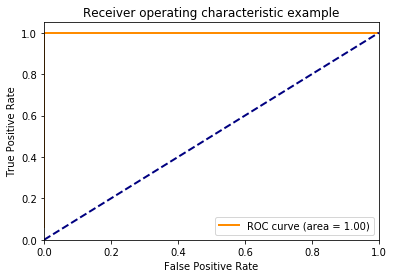

In [60]:
fpr, tpr, thresholds = roc_curve(y.values, ypred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y.values, ypred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Feature Importance

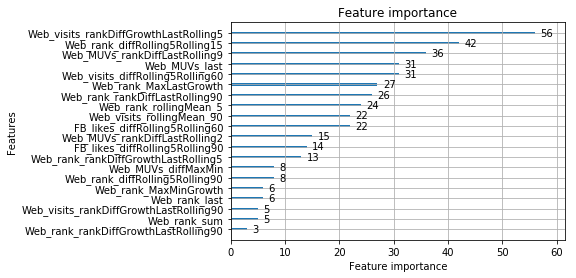

In [61]:
lgb.plot_importance(gbm, max_num_features=20)

In [62]:
importance = pd.DataFrame()
importance['features'] = gbm.feature_name()
importance['importance'] = gbm.feature_importance(importance_type='split', iteration=-1)

In [63]:
importance = importance.sort_values(by = 'importance', ascending = False).reset_index(drop = True)
importance[0:15]

,features,importance
0,Web_visits_rankDiffGrowthLastRolling5,56
1,Web_rank_diffRolling5Rolling15,42
2,Web_MUVs_rankDiffLastRolling9,36
3,Web_visits_diffRolling5Rolling60,31
4,Web_MUVs_last,31
5,Web_rank_MaxLastGrowth,27
6,Web_rank_rankDiffLastRolling90,26
7,Web_rank_rollingMean_5,24
8,FB_likes_diffRolling5Rolling60,22
9,Web_visits_rollingMean_90,22


### Model Interpretation

The lower the Web rank (best company ranks 1), the better the company.  
Recent observations are more important than the past performance.  Rolling Mean of 5 days is the most important features, rather than rolling mean of longer periods.  

Text(0.5,1,'Web rank_rollingMean_5')

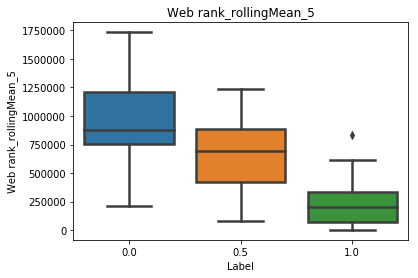

In [64]:
ax = sns.boxplot(x="Label", y="Web rank_rollingMean_5", data=company, linewidth=2.5)
plt.title("Web rank_rollingMean_5")

Good company have either a stable web rank, or an improvement in web rank.
Stabalization is measured by the differences between rolling 90 day average and rolling 5 days averages.  The smaller the differences, the more stable the web rank is.  <br>Bad companies are signaled by a drop in ranks, which are represented by the negative values.  

Text(0.5,1,'Web rank_diffRolling5Rolling90')

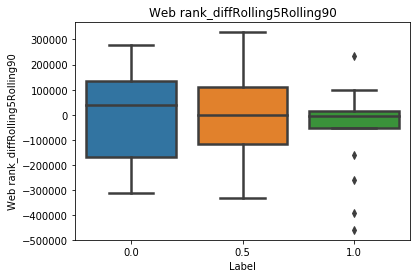

In [65]:
var = 'Web rank_diffRolling5Rolling90'
ax = sns.boxplot(x="Label", y= var, data=company, linewidth=2.5)
plt.title(var)